## 8.1.1 Sellers

The table sellers contains 3095 sellers that use Olist's services. Let's have a look at the first few rows:

In [1]:
import sqlite3
import pandas as pd
db_path = 'C:/Users/gregoG/Documents/python/Olist_analysis/olist.sqlite'
db_connection = sqlite3.connect(db_path)

Are most sellers small, with a few sales, or large companies with a high volume of sales? How do review scores vary among the different sellers? We can answer both of those questions using a scatterplot. Let's get the data we need from the sellers table:

In [3]:
seller_review_scores_and_sales = '''
SELECT 
    sellers.seller_id,
    AVG(order_reviews.review_score) AS avg_review_score,
    SUM(order_items.price) AS total_sales,
    COUNT(orders.order_id) AS num_orders
FROM 
    sellers
    LEFT JOIN order_items ON sellers.seller_id = order_items.seller_id
    LEFT JOIN orders ON order_items.order_id = orders.order_id
    LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
GROUP BY 
    sellers.seller_id
HAVING 
    COUNT(orders.order_id) > 10
'''

df = pd.read_sql_query(seller_review_scores_and_sales, db_connection)
df

,seller_id,avg_review_score,total_sales,num_orders
0,001cca7ae9ae17fb1caed9dfb1094831,3.902542,25080.03,239
1,002100f778ceb8431b7a1020ff7ab48f,3.982143,1254.40,56
2,004c9cd9d87a3c30c522c48c4fc07416,4.132948,20467.18,176
3,00720abe85ba0859807595bbf045a33b,3.653846,1007.50,26
4,00ee68308b45bc5e2660cd833c3f81cc,4.331395,20345.00,173
...,...,...,...,...
1310,ffc470761de7d0232558ba5e786e57b7,4.300000,1649.01,31
1311,ffdd9f82b9a447f6f8d4b91554cc7dd3,4.250000,2101.20,20
1312,ffeee66ac5d5a62fe688b9d26f83f534,4.214286,1839.86,14
1313,fffd5413c0700ac820c7069d66d98c89,3.866667,9062.30,61


## 8.1.2 Visualization

We'll create a scatterplot where each point is a seller, the y-axis indicates its average order review score, the x-axis shows total sales, using a logarithmic scale, since most sellers have very low sales. We'll also use both color and size to represent the number of orders:

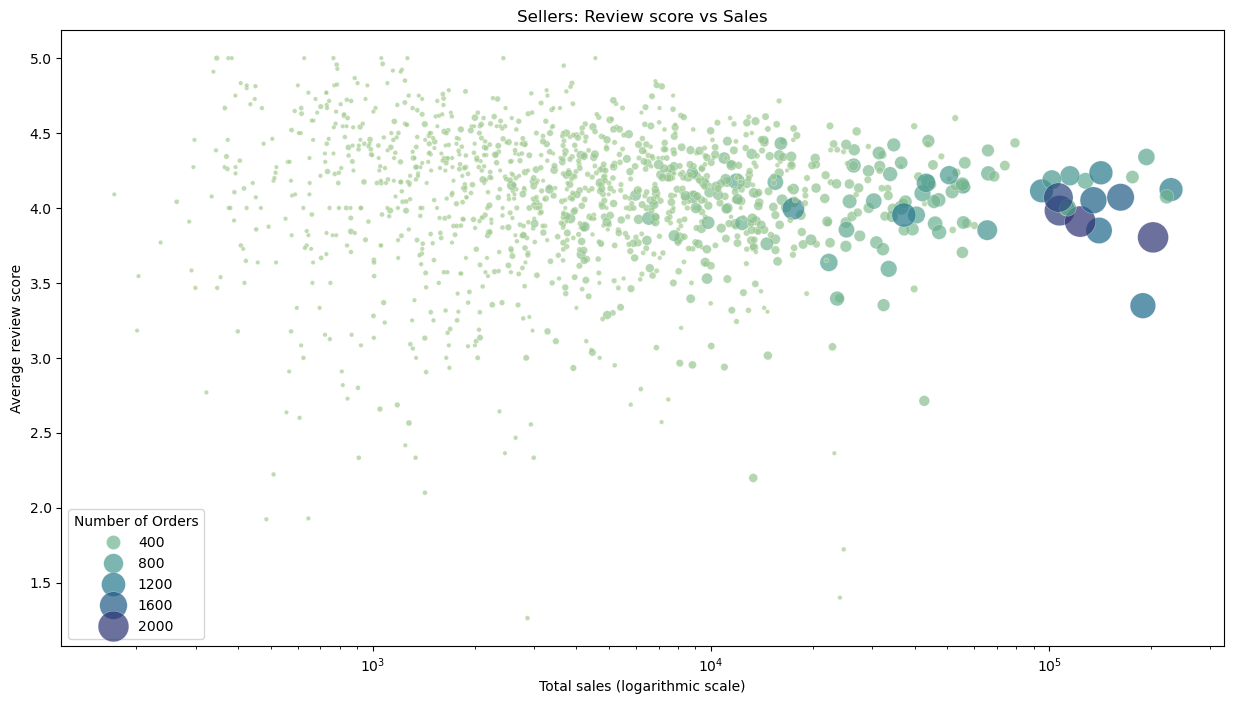

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='total_sales', y='avg_review_score', size='num_orders', sizes=(10, 500), 
                hue='num_orders', palette='crest', alpha=0.7)
plt.xscale('log')
plt.xlabel('Total sales (logarithmic scale)')
plt.ylabel('Average review score')
plt.title('Sellers: Review score vs Sales')
plt.legend(title='Number of Orders')
plt.show()

As we can see, most of Olist's sellers are small, with just a few orders. As you'd expect, larger sellers have less variance in their average order review scores, with most sellers being in the range between 3.5 and 4.5. Notice in the group of large sellers at the right of the plot, there's a seller with significantly lower scores than its peers. We can also observe that there are sellers with the same amount of total sales but significantly different numbers of orders (bubbles with different sizes in the same x position), meaning that some sellers have significantly higher average order value than others.



## 8.2 Numer of sellers by order size

Let's build another plot to help us understand the distribution of sellers by order size. We'll sort the sellers into 4 groups according to the number of orders they dispatched:

- Group 1: Sellers with 1-9 orders.
- Group 2: Sellers with 10-99 orders.
- Group 3: Sellers with 100-199 orders.
- Group 4: Sellers with 1000 or more orders.

In [10]:
bucketed_sellers = """
SELECT
    seller_id,
    CASE 
        WHEN COUNT(order_id) BETWEEN 1 AND 9 THEN '1-9 orders'
        WHEN COUNT(order_id) BETWEEN 10 AND 99 THEN '10-99 orders'
        WHEN COUNT(order_id) BETWEEN 100 AND 999 THEN '100-999 orders'
        ELSE '1000+ orders'
    END AS bucket
FROM order_items
GROUP BY seller_id
"""

pd.read_sql_query(bucketed_sellers, db_connection).head(5)

,seller_id,bucket
0,0015a82c2db000af6aaaf3ae2ecb0532,1-9 orders
1,001cca7ae9ae17fb1caed9dfb1094831,100-999 orders
2,001e6ad469a905060d959994f1b41e4f,1-9 orders
3,002100f778ceb8431b7a1020ff7ab48f,10-99 orders
4,003554e2dce176b5555353e4f3555ac8,1-9 orders


In [11]:
sellers_per_bucket = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT 
    bucket,
    COUNT(seller_id) AS seller_count
FROM BucketedSellers
GROUP BY bucket
"""

seller_buckets = pd.read_sql_query(sellers_per_bucket, db_connection)
seller_buckets

,bucket,seller_count
0,1-9 orders,1714
1,10-99 orders,1142
2,100-999 orders,226
3,1000+ orders,13


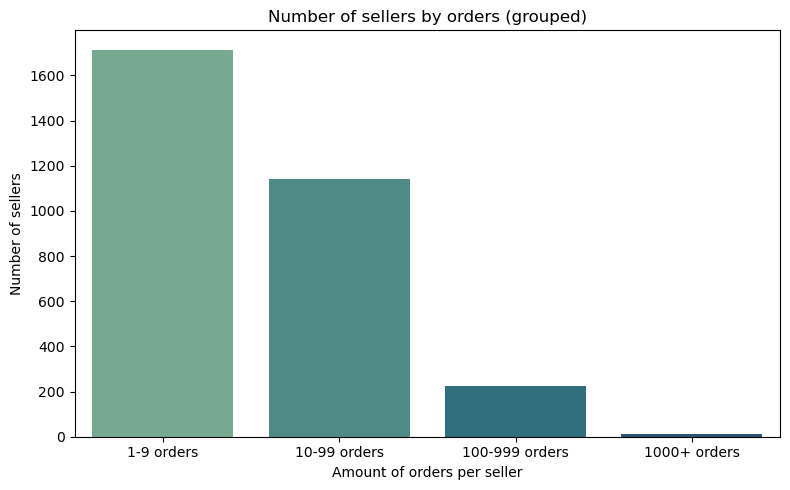

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(x='bucket', y='seller_count', data=seller_buckets, hue='bucket', palette='crest', dodge=False)
plt.title('Number of sellers by orders (grouped)')
plt.xlabel('Amount of orders per seller')
plt.ylabel('Number of sellers')
plt.tight_layout()
plt.show()

We can verify most sellers are small, with very few having more than 1000 orders.

## 8.3 Sellers shipping time

Do larger sellers have lower shipping times? To answer this question let's build a plot of the distribution of shipping time for each of the previous four groups. We'll reuse the previous CTE in the query to get the data we need:

In [16]:
seller_shipping_times = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT
    bucket,
    BucketedSellers.seller_id,
    JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)
        AS delivery_time
FROM orders
    JOIN order_items USING (order_id)
    JOIN BucketedSellers USING (seller_id)
WHERE order_status = 'delivered'
"""

df = pd.read_sql_query(seller_shipping_times, db_connection)
df

,bucket,seller_id,delivery_time
0,10-99 orders,3504c0cb71d7fa48d967e0e4c94d59d9,8.436574
1,100-999 orders,289cdb325fb7e7f891c38608bf9e0962,13.782037
2,1000+ orders,4869f7a5dfa277a7dca6462dcf3b52b2,9.394213
3,100-999 orders,66922902710d126a0e7d26b0e3805106,13.208750
4,100-999 orders,2c9e548be18521d1c43cde1c582c6de8,2.873877
...,...,...,...
110192,10-99 orders,1f9ab4708f3056ede07124aad39a2554,22.193727
110193,10-99 orders,d50d79cb34e38265a8649c383dcffd48,24.859421
110194,100-999 orders,a1043bafd471dff536d0c462352beb48,17.086424
110195,100-999 orders,a1043bafd471dff536d0c462352beb48,17.086424


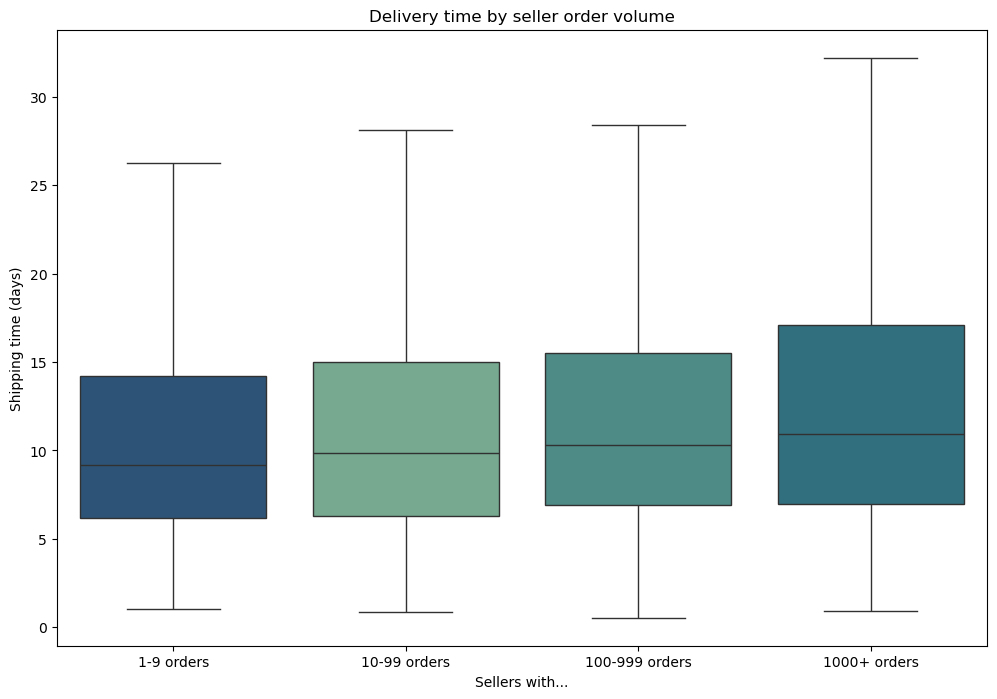

In [19]:
plt.figure(figsize=(12, 8))
palette = sns.color_palette('flare', len(seller_buckets['bucket']))
sns.boxplot(x='bucket', y='delivery_time', data=df, order=seller_buckets['bucket'], showfliers=False,
            hue='bucket', palette='crest', dodge=False)
plt.title('Delivery time by seller order volume')
plt.xlabel('Sellers with...')
plt.ylabel('Shipping time (days)')
plt.show()

Somehow, the larger the seller is, the longer deliveries tend to take. What causes this increase in shipping times? Do smaller sellers take less time between order approval and handing the package to the shipping company?